In [121]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
import sklearn.metrics as mtcs
import sklearn.preprocessing as pp
import sklearn.linear_model as lm
import sklearn.ensemble as ens
import sklearn.feature_selection as fs
import sklearn.neural_network as nn

from sklearn.pipeline import Pipeline
from sklearn.linear_model.base import BaseEstimator
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from tqdm import tqdm
from statsmodels.stats.weightstats import ztest
from xgboost import XGBClassifier
from tempfile import mkdtemp

%matplotlib inline
output_notebook()

Loading BokehJS ...

# Common functions

In [66]:
ALL = 1524

def weight_init(name, shape):
    return tf.get_variable(name, initializer=tf.random_normal(shape=shape,
                                                              stddev=0.1))
def bias_init(name, shape):
    return tf.get_variable(name, initializer=tf.constant(0.1, shape=shape))

def elastic_net(x, l1, l2):
    return l1 * ( (1-l2) / 2 * tf.norm(x, 2) ** 2 + 
                   l2 * tf.norm(x, 1))

def batch_data(*matrxs, batch_size):
    for batch_i in range(matrxs[0].shape[0] // batch_size):
        yield tuple(x.iloc[batch_i * batch_size : (batch_i + 1) * batch_size] 
                     for x in matrxs)
        
def split_data3(data, train_size=0.5, test_size=0.25, validate_size=0.25):
    train_data, test_val_data = ms.train_test_split(data, train_size=train_size)
    test_data, val_data = ms.train_test_split(test_val_data,
                                              train_size=test_size / (test_size+validate_size))
    
    train_X, train_y = train_data.drop('y', axis=1), train_data[['y']]
    test_X, test_y = test_data.drop('y', axis=1), test_data[['y']]
    validate_X, validate_y = val_data.drop('y', axis=1), val_data[['y']]
    
    return (train_X, train_y, test_X, test_y, validate_X, validate_y)

def split_data2(data, train_size, test_size):
    train_data, test_data = ms.train_test_split(data, train_size=train_size,
                                                stratify=data.y)
    train_X, train_y = train_data.drop('y', axis=1), train_data[['y']]
    test_X, test_y = test_data.drop('y', axis=1), test_data[['y']]
    
    return (train_X, train_y, test_X, test_y)
    

def pp_pipeline(data):
    scaler = pp.StandardScaler()
    
    data_pp = scaler.fit_transform(data)
    
    data_pp = pd.DataFrame(data_pp,
                        index=data.index,
                        columns=data.columns)
    
    #restore target
    data_pp.y = data.y
    
    return data_pp

# Data uploading&preview

In [3]:
data = _data_ = pd.read_csv('./data/train.csv')

data

,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,...,feature-1515,feature-1516,feature-1517,feature-1518,feature-1519,feature-1520,feature-1521,feature-1522,feature-1523,y
0,37.977273,6.758452,3.636364,10.792929,160.801682,151.109783,1.791689,6.818675,8.138413,8.270161,...,5.658393,4.151040,4.540632,4.953183,5.351562,5.311048,5.560922,5.643015,5.715999,0.0
1,19.408163,5.933978,2.816327,5.877551,162.949911,76.153796,1.381401,6.002651,5.080499,7.514421,...,4.830811,3.817712,4.123094,4.426343,4.823804,4.652173,4.795274,4.860781,5.001426,0.0
2,40.265306,7.425645,3.734694,13.160998,172.099640,161.790879,1.603976,7.410120,10.114794,8.805738,...,6.397659,4.223177,4.685597,5.116870,5.333926,5.504569,5.797956,6.009581,6.200889,0.0
3,43.976744,7.648293,3.837209,14.392765,168.885456,175.277251,1.622298,7.629033,12.180817,9.070719,...,5.879135,4.280132,4.563045,5.007714,5.159773,5.393628,5.640132,5.472271,5.741399,0.0
4,24.320988,6.534011,3.567901,8.913580,163.076959,96.019681,1.380679,6.566695,4.417010,8.058783,...,8.148663,4.624973,5.173321,5.720312,6.259342,6.626469,7.062406,7.472998,7.829842,0.0
5,20.924051,6.134299,3.037975,6.506329,165.707039,82.761541,1.381957,6.187547,4.684599,7.660347,...,6.087556,4.430817,4.820282,5.183187,5.595176,5.489454,5.604998,5.847522,5.987080,0.0
6,34.150000,6.740695,3.733333,10.214815,164.252922,135.639059,1.620887,6.781702,8.631090,8.248393,...,6.198225,4.471639,4.801970,5.237107,5.493833,5.573816,5.764799,5.865760,5.998937,0.0
7,23.833333,6.395508,3.141026,8.717949,163.221967,94.106131,1.435936,6.443753,5.834402,7.904135,...,6.582328,4.600158,5.032071,5.499726,5.978728,5.995208,6.179952,6.364051,6.481290,0.0
8,32.380952,6.152543,2.857143,6.402116,164.380868,128.391104,1.687697,6.232890,4.476844,7.736528,...,0.000000,3.449988,3.865979,4.506730,4.765906,4.965028,3.840795,3.595598,0.000000,0.0
9,45.228571,6.608449,3.714286,9.180952,159.167580,180.141749,1.981354,6.690537,8.428546,8.221041,...,5.214936,3.828641,4.234107,4.682131,4.890349,5.192957,5.342334,5.402677,5.303305,0.0


[ 0.  1.]


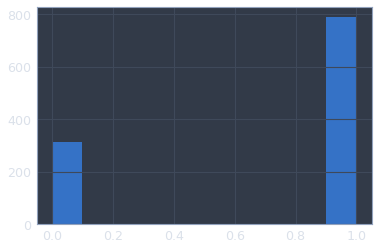

In [4]:
print(data.y.unique())
plt.hist(data.y);

In [5]:
print(data.isnull().sum().sum())

num_1 = data[data.y == 1].shape[0] 
num_0 = data[data.y == 0].shape[0]

print(num_1, num_0, num_1 / (num_0 + num_1))

0
790 315 0.7149321266968326


In [67]:
data = pp_pipeline(_data_)

data_X = data.drop('y', axis=1)
data_y = data[['y']]

In [68]:
(train_X, train_y, test_X, test_y) = split_data2(data, train_size=0.8, test_size=0.2)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Feature selection

## DFS

In [8]:
class DFS(BaseEstimator):
    def __init__(self, layers_sizes=[128, 64, 2], batch_size=32, lambda1=1e-3, lambda2=1.,
                 alpha1=1e-3, alpha2=0., num_epochs=10, verbose=0, N=None):
        self.layers_sizes = layers_sizes
        self.num_layers = len(layers_sizes)
        self.batch_size = batch_size
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_epochs = num_epochs
        self.verbose = verbose
        self.N = N
        
        
    def fit(self, X, y, test_data=None):
        self._build_graph_(X.shape[1])
        self.features = X.columns #Persisting for `select_most_important_ftrs`
        self.sess = tf.Session()
        
        self.sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(self.num_epochs):
            X_cur = X.sample(frac=1, random_state=epoch_i)
            y_cur = y.sample(frac=1, random_state=epoch_i)
            epoch_loss = 0
            for batch_X, batch_y in batch_data(X_cur, y_cur, 
                                               batch_size=self.batch_size):
                train_loss, _ = self.sess.run([self.total_loss, self.train_step],
                                               feed_dict = {self.x: batch_X,
                                                            self.y: batch_y})
                epoch_loss += train_loss
            epoch_loss /= X.shape[0] // self.batch_size
            
            train_predict = self.predict(X_cur)
            train_accuracy = mtcs.accuracy_score(y_cur, train_predict)
            if self.verbose:
                if test_data is not None:
                    test_X, test_y = test_data
                    test_predict = self.predict(test_X)
                    test_accuracy = mtcs.accuracy_score(test_y, test_predict)
                    print(f"==> Epoch: {epoch_i}. Train loss: {epoch_loss}."
                          f"Train accuracy: {train_accuracy}. Test accuracy: {test_accuracy}.")
                else:
                    print(f"==> Epoch: {epoch_i}. Train loss: {epoch_loss}. "
                          f"Train accuracy: {train_accuracy}.")
                
        return self
       
    
    def predict_proba(self, X):
        predictions_proba = self.sess.run(self.predictions, feed_dict={self.x: X})
        
        return predictions_proba
    
    
    def predict(self, X):
        predictions_proba = self.predict_proba(X)
        
        return list(map(np.argmax, predictions_proba))
    
    
    def get_features_weights(self):
        weights = self.sess.run(self.features_weights)
        
        return weights
    
    
    def select_most_important_ftrs(self, N):
        weights = self.get_features_weights()
        feature_weight = sorted(zip(weights, self.features), 
                                key=lambda x: abs(x[0]))
        
        return map(lambda x: x[1], feature_weight[-N:])
    
    
    def transform(self, X, N=None):
        if N:
            features = list(self.select_most_important_ftrs(N))
        else:
            features = list(self.select_most_important_ftrs(self.N))
        
        return X[features]
    
     
    def _build_graph_(self, num_features):
        tf.reset_default_graph()
        
        ###Placeholders 
        x = tf.placeholder(tf.float32, [None, num_features], 'x_ph')
        y = tf.placeholder(tf.int32, [None], 'y_ph')
        
        ###Weights initialization
        w = tf.get_variable("dfs_features_weight", 
                            initializer = tf.constant(1., shape=[num_features]))
        self.layers_sizes = [num_features] + self.layers_sizes
        W, b = [], []
        for layer_i in range(self.num_layers):
            W.append(weight_init(f"layer_{layer_i}_weights",
                                 shape=[self.layers_sizes[layer_i],
                                        self.layers_sizes[layer_i+1]]))
            b.append(bias_init(f"layer_{layer_i}_bias",
                               shape=[self.layers_sizes[layer_i+1]]))
        
        ###Input transformations
        logits = x * w #feature selection
        for layer_i in range(self.num_layers):
            if layer_i != self.num_layers - 1:
                logits = tf.nn.tanh(tf.matmul(logits, W[layer_i]) + b[layer_i])
            else:
                logits = tf.matmul(logits, W[layer_i]) + b[layer_i]
        predictions = tf.nn.softmax(logits)
            
        ###Loss calculation
        logloss = tf.reduce_sum(
                        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, 
                                                                       logits=logits))
        w_loss = elastic_net(w, self.lambda1, self.lambda2)
        W_loss = tf.reduce_sum([elastic_net(W_i, self.alpha1, self.alpha2) for W_i in W])
        
        total_loss = tf.reduce_sum(logloss + w_loss + W_loss)
        
        ###Optimizer
        train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)
        
        self.x = x
        self.y = y
        self.predictions = predictions
        self.total_loss = total_loss
        self.train_step = train_step
        self.features_weights = w
        

In [11]:
dfs = DFS([128, 64, 2], num_epochs=200)

dfs.fit(train_X, train_y['y'], test_data=(test_X, test_y))

DFS(N=None, alpha1=0.001, alpha2=0.0, batch_size=32, lambda1=0.001,
  lambda2=1.0, layers_sizes=[1524, 128, 64, 2], num_epochs=200, verbose=0)

(array([ 149.,    7.,    6.,   16.,   26.,  237.,  703.,  312.,   53.,   15.]),
 array([ -2.71258759e-04,   1.15846904e-01,   2.31965067e-01,
          3.48083229e-01,   4.64201392e-01,   5.80319555e-01,
          6.96437717e-01,   8.12555880e-01,   9.28674043e-01,
          1.04479221e+00,   1.16091037e+00]),
 <a list of 10 Patch objects>)

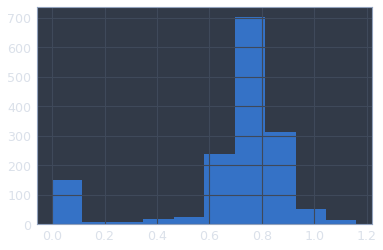

In [12]:
plt.hist(dfs.get_features_weights())

## Lasso

In [87]:
class LassoFS(BaseEstimator):
    def __init__(self, N=None):
        self.N = N
        self.est = lm.LogisticRegression(penalty='l1')
    
    
    def fit(self, X, y):
        self.est.fit(X, y)
        self.features = train_X.columns
        
        return self
    
    
    def transform(self, X, N=None):
        if N:
            features = list(self.select_most_important_ftrs(N))
        else:
            features = list(self.select_most_important_ftrs(self.N))
        
        return X[features]

    
    def predict(self, X):
        return self.est.predict(X)
    
    
    @property
    def coef_(self):
        return self.est.coef_


    def select_most_important_ftrs(self, N):
        feature_weight = sorted(zip(self.est.coef_[0], self.features),
                                key=lambda x: abs(x[0]))

        return list(map(lambda x: x[1], feature_weight[-N:]))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.841628959276


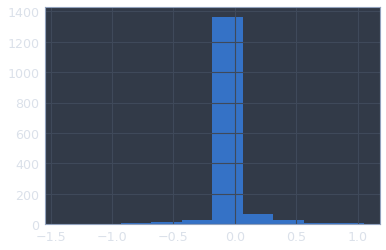

In [14]:
est = LassoFS();
est.fit(train_X, train_y.y);
print(mtcs.accuracy_score(test_y, est.predict(test_X)))
plt.hist(est.coef_[0]);

## Random forest

In [15]:
class RandomForestFS(BaseEstimator):
    def __init__(self, N=None):
        self.N = N
        self.est = ens.RandomForestClassifier()
        
        
    def fit(self, X, y):
        self.est.fit(X, y)
        self.features = X.columns
        
        return self
    
    
    def transform(self, X, N=None):
        if N:
            features = self.select_most_important_ftrs(N)
        else:
            features = self.select_most_important_ftrs(self.N)
            
        return X[features]

    
    def predict(self, X):
        return self.est.predict(X)
    
    
    @property
    def feature_importances_(self):
        return self.est.feature_importances_
    
    
    def select_most_important_ftrs(self, N):
        feature_weight = sorted( zip(self.est.feature_importances_,
                                     self.features),
                                 key=lambda x: x[0])
        return list(map(lambda x: x[1], feature_weight[-N:]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.877828054299


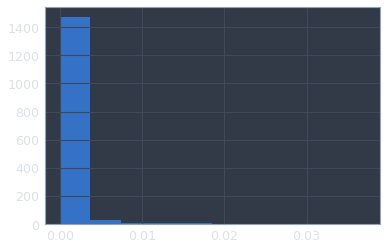

In [16]:
est = RandomForestFS();
est.fit(train_X, train_y);
print(mtcs.accuracy_score(test_y, est.predict(test_X)))
plt.hist(est.feature_importances_);

# Classification models

## Random Forest

In [20]:
est = ens.RandomForestClassifier()

train_X_dfs = dfs.transform(train_X, 500)
test_X_dfs = dfs.transform(test_X, 500)

est.fit(train_X_dfs, train_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
mtcs.accuracy_score(test_y, est.predict(test_X_dfs))

0.85520361990950222

In [22]:
plt.hist(acc_p)
plt.show()
plt.hist(acc_dfs)

NameError: name 'acc_p' is not defined

In [107]:
ztest(acc_p, acc_dfs)

(-1.8637867739884362, 0.062351653820433672)

## Gradient Boosting

In [ ]:
def select_most_important_ftrs(est, features, N):
    feature_weight = sorted(zip(est.coef_[0], features),
                            key=lambda x: abs(x[0]))
    
    return list(map(lambda x: x[1], feature_weight[-N:]))

In [128]:
est = XGBClassifier(n_estimators=1000, n_jobs=40, silent=False)

est.fit(train_X_dfs, train_y, verbose=True)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=40, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=False, subsample=1)

In [124]:
mtcs.accuracy_score(test_y, est.predict(test_X))

0.8876811594202898

In [125]:
est.feature_importances_

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

# Hyperparameters optimization

In [109]:
NUM_FEATURES = [10, 50, 100, 150, 200, 250, 300, 350, 400, 500, 750, 1000,  ALL]

In [110]:
def evaluate(main_model, feature_selector, param_grid, 
             X, y, scoring='accuracy', caching=False):

    if main_model is not None:
        pipeline_list = [('select_ftrs', feature_selector),
                         ('main', main_model)]
    else:
        pipeline_list = [('select_ftrs', feature_selector)]

    if caching:
        pipeline = Pipeline(pipeline_list, memory=mkdtemp())
    else:
        pipeline = Pipeline(pipeline_list)
    
    grid = ms.GridSearchCV(pipeline, cv=ms.StratifiedKFold(shuffle=True),
                           n_jobs=1, param_grid=param_grid,
                           verbose=100, scoring=scoring)
    grid.fit(X, y)
    
    return grid

In [111]:
all_scores = dict()

In [112]:
##### DFS + RandomForest #####
param_grid = [
    {
     'select_ftrs__N': NUM_FEATURES
#      'select_ftrs__lambda1': np.arange(0, 0.05, 0.005)
#      'main__n_estimators': [10, 25, 50]
    }
]

all_scores['DFS + RF'] = evaluate(ens.RandomForestClassifier(),
                                  DFS(), param_grid, data_X, data_y.y)

Fitting 3 folds for each of 13 candidates, totalling 39 fits
[CV] select_ftrs__N=10 ...............................................
[CV] ...... select_ftrs__N=10, score=0.8184281842818428, total=   3.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[CV] select_ftrs__N=10 ...............................................
[CV] ................... select_ftrs__N=10, score=0.875, total=   2.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s
[CV] select_ftrs__N=10 ...............................................
[CV] ...... select_ftrs__N=10, score=0.8505434782608695, total=   2.5s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.2s remaining:    0.0s
[CV] select_ftrs__N=50 ...............................................
[CV] ...... select_ftrs__N=50, score=0.8563685636856369, total=   2.6s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.8s remaining:    0.0s
[CV] select_ftrs__N=50 ............................

[CV] .... select_ftrs__N=1524, score=0.8614130434782609, total=   2.7s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:  1.8min remaining:    0.0s
[CV] select_ftrs__N=1524 .............................................
[CV] .... select_ftrs__N=1524, score=0.8396739130434783, total=   2.6s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  1.8min finished


In [113]:
##### DFS + Gradient Boosting #####
param_grid = [
    {
     'select_ftrs__N': NUM_FEATURES
    }
]

all_scores['DFS + GB'] = evaluate(XGBClassifier(),
                                  DFS(), param_grid, data_X, data_y.y)

Fitting 3 folds for each of 13 candidates, totalling 39 fits
[CV] select_ftrs__N=10 ...............................................
[CV] ...... select_ftrs__N=10, score=0.8238482384823849, total=   3.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[CV] select_ftrs__N=10 ...............................................
[CV] ...... select_ftrs__N=10, score=0.8722826086956522, total=   2.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s
[CV] select_ftrs__N=10 ...............................................
[CV] ...... select_ftrs__N=10, score=0.8559782608695652, total=   2.5s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.9s remaining:    0.0s
[CV] select_ftrs__N=50 ...............................................
[CV] ...... select_ftrs__N=50, score=0.8590785907859079, total=   3.4s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.3s remaining:    0.0s
[CV] select_ftrs__N=50 ............................

[CV] .... select_ftrs__N=1524, score=0.8885869565217391, total=   8.1s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:  2.6min remaining:    0.0s
[CV] select_ftrs__N=1524 .............................................
[CV] .... select_ftrs__N=1524, score=0.8858695652173914, total=   7.7s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  2.8min finished


In [114]:
##### LassoFS + RandomForest #####
param_grid = [
    {
     'select_ftrs__N':  NUM_FEATURES
    }
]

all_scores['Lasso + RF'] =  evaluate(ens.RandomForestClassifier(),
                                     LassoFS(), param_grid, data_X, data_y.y)

Fitting 3 folds for each of 13 candidates, totalling 39 fits
[CV] select_ftrs__N=10 ...............................................
[CV] ...... select_ftrs__N=10, score=0.8834688346883469, total=   0.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[CV] select_ftrs__N=10 ...............................................
[CV] ................... select_ftrs__N=10, score=0.875, total=   0.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[CV] select_ftrs__N=10 ...............................................
[CV] ...... select_ftrs__N=10, score=0.8260869565217391, total=   0.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[CV] select_ftrs__N=50 ...............................................
[CV] ...... select_ftrs__N=50, score=0.8970189701897019, total=   0.4s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s
[CV] select_ftrs__N=50 ............................

[CV] ..... select_ftrs__N=1524, score=0.845108695652174, total=   0.6s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   14.7s remaining:    0.0s
[CV] select_ftrs__N=1524 .............................................
[CV] .... select_ftrs__N=1524, score=0.8260869565217391, total=   0.5s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   15.2s finished


In [115]:
##### LassoFS + GradientBoosting #####
param_grid = [
    {
     'select_ftrs__N':  NUM_FEATURES
    }
]

all_scores['Lasso + GB'] = evaluate(XGBClassifier(),
                                    LassoFS(), param_grid, data_X, data_y.y)

Fitting 3 folds for each of 13 candidates, totalling 39 fits
[CV] select_ftrs__N=10 ...............................................
[CV] ...... select_ftrs__N=10, score=0.8644986449864499, total=   0.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[CV] select_ftrs__N=10 ...............................................
[CV] ...... select_ftrs__N=10, score=0.8614130434782609, total=   0.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[CV] select_ftrs__N=10 ...............................................
[CV] ...... select_ftrs__N=10, score=0.8641304347826086, total=   0.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[CV] select_ftrs__N=50 ...............................................
[CV] ...... select_ftrs__N=50, score=0.8726287262872628, total=   0.4s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
[CV] select_ftrs__N=50 ............................

[CV] .... select_ftrs__N=1524, score=0.8858695652173914, total=   5.7s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   55.8s remaining:    0.0s
[CV] select_ftrs__N=1524 .............................................
[CV] .... select_ftrs__N=1524, score=0.8614130434782609, total=   6.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  1.0min finished


In [116]:
##### Pure DFS #####
param_grid = [
    {
     'select_ftrs__N':  NUM_FEATURES
    }
]

all_scores['DFS'] = evaluate(None, DFS(),
                             param_grid, data_X, data_y.y)

Fitting 3 folds for each of 13 candidates, totalling 39 fits
[CV] select_ftrs__N=10 ...............................................
[CV] ...... select_ftrs__N=10, score=0.8699186991869918, total=   2.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[CV] select_ftrs__N=10 ...............................................
[CV] ...... select_ftrs__N=10, score=0.8478260869565217, total=   2.5s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s
[CV] select_ftrs__N=10 ...............................................
[CV] ...... select_ftrs__N=10, score=0.8505434782608695, total=   2.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.8s remaining:    0.0s
[CV] select_ftrs__N=50 ...............................................
[CV] ...... select_ftrs__N=50, score=0.8672086720867209, total=   2.5s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.4s remaining:    0.0s
[CV] select_ftrs__N=50 ............................

[CV] .... select_ftrs__N=1524, score=0.8260869565217391, total=   3.1s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:  1.7min remaining:    0.0s
[CV] select_ftrs__N=1524 .............................................
[CV] .... select_ftrs__N=1524, score=0.8315217391304348, total=   2.5s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  1.7min finished


In [117]:
##### Pure Lasso #####
param_grid = [
    {
     'select_ftrs__N':  NUM_FEATURES
    }
]

all_scores['Lasso'] = evaluate( None, LassoFS(),
                             param_grid, data_X, data_y.y)

Fitting 3 folds for each of 13 candidates, totalling 39 fits
[CV] select_ftrs__N=10 ...............................................
[CV] ...... select_ftrs__N=10, score=0.8644986449864499, total=   0.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[CV] select_ftrs__N=10 ...............................................
[CV] ...... select_ftrs__N=10, score=0.8586956521739131, total=   0.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[CV] select_ftrs__N=10 ...............................................
[CV] ...... select_ftrs__N=10, score=0.8152173913043478, total=   0.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[CV] select_ftrs__N=50 ...............................................
[CV] ...... select_ftrs__N=50, score=0.8644986449864499, total=   0.4s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s
[CV] select_ftrs__N=50 ............................

[CV] .... select_ftrs__N=1524, score=0.8586956521739131, total=   0.3s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   13.5s remaining:    0.0s
[CV] select_ftrs__N=1524 .............................................
[CV] .... select_ftrs__N=1524, score=0.8179347826086957, total=   0.4s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   14.0s finished


In [122]:
##### DFS + MLP #####
param_grid = [
    {
        'select_ftrs__N': NUM_FEATURES
    }
]

all_scores['DFS + MLP'] = evaluate(nn.MLPClassifier(), DFS(),
                                   param_grid, data_X, data_y.y)

Fitting 3 folds for each of 13 candidates, totalling 39 fits
[CV] select_ftrs__N=10 ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ...... select_ftrs__N=10, score=0.8644986449864499, total=   5.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s
[CV] select_ftrs__N=10 ...............................................
[CV] ...... select_ftrs__N=10, score=0.8179347826086957, total=   3.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s
[CV] select_ftrs__N=10 ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ...... select_ftrs__N=10, score=0.8342391304347826, total=   3.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s
[CV] select_ftrs__N=50 ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ...... select_ftrs__N=50, score=0.8617886178861789, total=   4.7s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.4s remaining:    0.0s
[CV] select_ftrs__N=50 ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ...... select_ftrs__N=50, score=0.8641304347826086, total=   4.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.5s remaining:    0.0s
[CV] select_ftrs__N=50 ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ...... select_ftrs__N=50, score=0.8695652173913043, total=   3.8s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   24.3s remaining:    0.0s
[CV] select_ftrs__N=100 ..............................................
[CV] ..... select_ftrs__N=100, score=0.8672086720867209, total=   3.9s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   28.2s remaining:    0.0s
[CV] select_ftrs__N=100 ..............................................
[CV] ..... select_ftrs__N=100, score=0.8641304347826086, total=   4.7s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   32.9s remaining:    0.0s
[CV] select_ftrs__N=100 ..............................................
[CV] ..... select_ftrs__N=100, score=0.8668478260869565, total=   4.1s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   37.0s remaining:    0.0s
[CV] select_ftrs__N=150 ..............................................
[CV] ..... select_ftrs__N=150, score=0.8617886178861789, total=   4.1s
[Parallel(n_jobs=1)]: Done  10 out of  10

In [126]:
##### Lasso + MLP #####
param_grid = [
    {
        'select_ftrs__N': NUM_FEATURES
    }
]

all_scores['Lasso + MLP'] = evaluate(nn.MLPClassifier(), LassoFS(),
                                   param_grid, data_X, data_y.y)

Fitting 3 folds for each of 13 candidates, totalling 39 fits
[CV] select_ftrs__N=10 ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ...... select_ftrs__N=10, score=0.8590785907859079, total=   1.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[CV] select_ftrs__N=10 ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ...... select_ftrs__N=10, score=0.8532608695652174, total=   1.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[CV] select_ftrs__N=10 ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ...... select_ftrs__N=10, score=0.8478260869565217, total=   1.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s
[CV] select_ftrs__N=50 ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ...... select_ftrs__N=50, score=0.8617886178861789, total=   1.4s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.9s remaining:    0.0s
[CV] select_ftrs__N=50 ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ...... select_ftrs__N=50, score=0.8315217391304348, total=   1.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.4s remaining:    0.0s
[CV] select_ftrs__N=50 ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ...... select_ftrs__N=50, score=0.8559782608695652, total=   1.4s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    7.8s remaining:    0.0s
[CV] select_ftrs__N=100 ..............................................
[CV] ..... select_ftrs__N=100, score=0.8536585365853658, total=   1.5s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    9.4s remaining:    0.0s
[CV] select_ftrs__N=100 ..............................................
[CV] ..... select_ftrs__N=100, score=0.8505434782608695, total=   1.4s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   10.8s remaining:    0.0s
[CV] select_ftrs__N=100 ..............................................
[CV] ..... select_ftrs__N=100, score=0.8478260869565217, total=   1.4s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   12.2s remaining:    0.0s
[CV] select_ftrs__N=150 ..............................................
[CV] ..... select_ftrs__N=150, score=0.8644986449864499, total=   1.7s
[Parallel(n_jobs=1)]: Done  10 out of  10

# Plotting

In [127]:
colors = {'DFS + RF': 'blue',
          'DFS + GB': 'green',
          'Lasso + RF': 'red',
          'Lasso + GB': 'pink',
          'DFS': 'brown',
          'Lasso': 'orange',
          'DFS + MLP': 'greenyellow',
          'Lasso + MLP': 'cyan'}

In [128]:
def get_test_scores(all_scores, experiment):
    param_id = dict()
    cur_results = all_scores[experiment].cv_results_

    for i, params in enumerate(cur_results['params']):
        key = params['select_ftrs__N']
        if key in param_id:
            param_id[key].append(i)
        else:
            param_id[key] = [i]

    max_test_score = {}
    all_test_scores = {}
    for ts in param_id.keys():
        all_test_scores[ts] = cur_results['mean_test_score'][param_id[ts]]
        max_test_score[ts] = max(all_test_scores[ts])
    
    return max_test_score, all_test_scores

def plot(all_scores):
    p = figure(plot_width=1000)
    for i, score_title in enumerate(all_scores):
        max_scores, _ = get_test_scores(all_scores, score_title)
        
        p.line(x = list(max_scores.keys()), 
               y = list(max_scores.values()),
               legend=score_title,
               line_color=colors[score_title])
        p.circle(x = list(max_scores.keys()), 
               y = list(max_scores.values()),
               legend=score_title,
               color=colors[score_title],
               alpha=1.)
        
    
    p.legend.location = 'bottom_right'
    p.legend.click_policy = 'hide'

    show(p)

In [129]:
plot(all_scores)